In [2]:
import pandas as pd
from Portpolio import Portpolio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform

class PortpolioAnalysis(object):
  def __init__(self, pp:Portpolio, start:str, end:str):
    self.pp = pp
    self.date = pd.date_range(start,end)

  def make_df(self):
    portpolio_df = pd.DataFrame(self.date,columns=['Date'])
    for etf in self.pp.get_etf()[0]:
      df = etf.price_df
      df.index = pd.to_datetime(df['Date'], format="%Y-%m-%d")
      df = df.reindex(self.date)
      
      if 'Diff' not in df.columns:
        diff = df['Close'].iloc[1:].values - df['Close'].iloc[0:-1].values
        diff = np.insert(diff, 0, 0.0, axis=0)#list(zip(0.0, diff))
        df['Diff'] = diff
      #print(df[['Close','Diff']])

      portpolio_df[etf.name] = df['Diff'].values
    return portpolio_df.dropna(axis=0).set_index('Date')

  def standardize(self, df, ext_mean=np.array([]), ext_std=np.array([])):
    means = np.array([])
    stds = np.array([])
    for i, col in enumerate(df.columns):
      val = df[col].values
      if ext_mean.size:
        mean = ext_mean[i]
        std = ext_std[i]
      else:
        mean = np.mean(val)
        std = np.std(val)
        means = np.append(means, mean)
        stds = np.append(stds, std)
      val = (val-mean)/std
      df[col] = val
    #return df.reset_index()
    return df, means, stds

  def normalize(self, df):
    for col in df.columns:
      val = df[col].values
      max = np.max(df[col].values)
      min = np.min(df[col].values)
      val = (val-min)/(max-min)
      df[col] = val
    #return df.reset_index()
    return df


  def get_correlation(self,df):
    """ Return
      Correation Dataframe
    """
    if platform.system() == 'Darwin':
      plt.rc('font', family='AppleGothic')
      plt.rcParams['axes.unicode_minus'] = False
    else:
      plt.rcParams["font.family"] = 'NanumGothic'

    df = df.corr(method='pearson')
    return df

  def get_corr_plot(self, corr_df=None):
    """ Return
      plot()
    """
    assert corr_df.empty ==0 ,'please do get_correlation()'

    fig, ax = plt.subplots( figsize=(7,7) )

    if 0 :    # 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
      mask = np.zeros_like(corr_df, dtype=np.bool)
      mask[np.triu_indices_from(mask)] = True
    else:
      mask = 0

    sns.heatmap(corr_df, 
                cmap = 'RdYlBu_r', 
                annot = True,
                mask=mask,
                linewidths=.5,
                cbar_kws={"shrink": .5},
                vmin = -1,vmax = 1
              )  
    plt.show()

  def correation(self,df):
    col = df.columns
    return np.corrcoef(df[col[0]], df[col[1]])[0,1]


In [ ]:
po = Portpolio('LAA')
pa = PortpolioAnalysis(po, start='2010-01-03', end='2022-03-10')

# 1. 전처리
df = pa.make_df()
if 1:
  df,train_mean,train_std = pa.standardize(df=df) 
else:
  df = pa.normalize(df=df)

print(df)
# 2. scatter
if 0:
  index = df.columns
  plt.scatter(x=df[index[0]],y=df[index[2]],alpha=0.5)
  plt.xlabel(index[0])
  plt.ylabel(index[2])
else:
  index = df.columns
  plt.plot(df[index[0]])
  plt.plot(df[index[2]])

# 3. corr & corr_plot
if 0:
  corr_df = pa.get_correlation(df)
  pa.get_corr_plot(corr_df)

In [21]:
rolling = df.rolling(window=3).mean().dropna()
df = rolling
index = df.columns
data = df[[index[0],index[2]]]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scale = scaler.fit_transform(data)

/home/temp/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(
/home/temp/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


In [22]:
from sklearn.cluster import KMeans

k = 4

model = KMeans(n_clusters = k, random_state = 10)
model.fit(data_scale)
df['cluster'] = model.fit_predict(data_scale)
df

,QQQ,Bonds,Gold,cluster
Date,,,,
2010-01-05,0.083474,0.584947,0.662720,0
2010-01-06,0.034528,0.231134,1.176066,0
2010-01-07,-0.077351,0.014913,0.274165,0
2010-01-08,-0.010923,-0.260274,0.458518,0
2010-01-09,0.038024,0.093540,-0.054828,0
...,...,...,...,...
2022-03-06,-0.900714,1.076355,0.801689,3
2022-03-07,-2.208294,-0.486324,0.759153,3
2022-03-08,-2.472255,-1.203775,2.205592,3


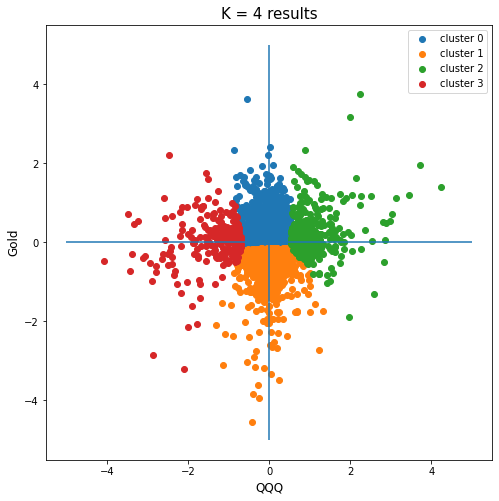

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(df.loc[df['cluster'] == i, index[0]], df.loc[df['cluster'] == i, index[2]], 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel(index[0], size = 12)
plt.ylabel(index[2], size = 12)
plt.vlines(x=0,ymin=-5,ymax=5)
plt.hlines(y=0,xmin=-5,xmax=5)
plt.show()